In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

In [2]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 0)
    
    # Create a new image from the converted array
    # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image) * 255, transforms.ToTensor()(lesion_free_image) * 255, transforms.ToTensor()(converted_array)

In [17]:
# dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# # randomly split dataset into train and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # create dataloaders for train and test sets
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dat = datasets.MNIST(
    "/home/user/Imperial-Year-4-DLCW2/data", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("/home/user/Imperial-Year-4-DLCW2/data", train=False, transform=transform)

train_dataloader = DataLoader(train_dat, 32, shuffle=True, num_workers=32)
test_dataloader = DataLoader(test_dat, 32, shuffle=False, num_workers=32)

In [35]:
# Write an autoencoder model using conv2d layers
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        # self.latent = nn.Sequential(
        #     nn.Linear(24 * 3 * 3, 100),
        #     nn.Linear(100, 24 * 3 * 3),
        #     nn.LeakyReLU(),
        # )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (24, 3, 3)),
            nn.ConvTranspose2d(24, 16, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, 6, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encode
        x = self.encoder(x)
        # x = self.latent(x)
        # decode
        x = self.decoder(x)
                
        return x

In [36]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 28, 28))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 7089
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
         LeakyReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 24, 7, 7]           3,480
         LeakyReLU-8             [-1, 24, 7, 7]               0
         MaxPool2d-9             [-1, 24, 3, 3]               0
          Flatten-10                  [-1, 216]               0
        Unflatten-11             [-1, 24, 3, 3]               0
  ConvTranspose2d-12             [-1, 16, 6, 6]           1,552
        LeakyReLU-13             [-1, 16, 6, 6]               0
  C

In [37]:
# Write the training loop for this model
from torch import optim

def train(model, train_dataloader, test_dataloader, num_epochs=5, learning_rate=0.0001):
    torch.manual_seed(42)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm.tqdm(train_dataloader):
            img, lesion_free_img = data
            img = img.to(device)
            # lesion_free_img = lesion_free_img.to(device)
            # weight_map = weight_map.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # ===================log========================
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        print('epoch [{}/{}], train loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))
        running_loss = 0.0
        for data in tqdm.tqdm(test_dataloader):
            model.eval()
            img, lesion_free_img = data
            img = img.to(device)
            # lesion_free_img = lesion_free_img.to(device)
            # weight_map = weight_map.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            running_loss += loss.item()
        # ===================log========================
        test_loss = running_loss / len(test_dataloader)
        test_losses.append(test_loss)
        print('epoch [{}/{}], test loss:{:.4f}'.format(epoch+1, num_epochs, test_loss))
    return train_losses, test_losses

model = Autoencoder().to(device)
train(model, train_dataloader, test_dataloader, num_epochs=10, learning_rate=0.0001)

100%|██████████| 1875/1875 [00:09<00:00, 189.20it/s]


epoch [1/10], train loss:0.3674


100%|██████████| 313/313 [00:02<00:00, 148.81it/s]


epoch [1/10], test loss:0.1823


100%|██████████| 1875/1875 [00:09<00:00, 188.08it/s]


epoch [2/10], train loss:0.1633


100%|██████████| 313/313 [00:02<00:00, 151.48it/s]


epoch [2/10], test loss:0.1463


100%|██████████| 1875/1875 [00:10<00:00, 184.62it/s]


epoch [3/10], train loss:0.1370


100%|██████████| 313/313 [00:02<00:00, 142.83it/s]


epoch [3/10], test loss:0.1278


100%|██████████| 1875/1875 [00:10<00:00, 182.46it/s]


epoch [4/10], train loss:0.1232


100%|██████████| 313/313 [00:02<00:00, 143.48it/s]


epoch [4/10], test loss:0.1172


100%|██████████| 1875/1875 [00:09<00:00, 187.90it/s]


epoch [5/10], train loss:0.1148


100%|██████████| 313/313 [00:02<00:00, 148.66it/s]


epoch [5/10], test loss:0.1108


100%|██████████| 1875/1875 [00:09<00:00, 191.44it/s]


epoch [6/10], train loss:0.1098


100%|██████████| 313/313 [00:02<00:00, 148.20it/s]


epoch [6/10], test loss:0.1069


100%|██████████| 1875/1875 [00:10<00:00, 183.84it/s]


epoch [7/10], train loss:0.1062


100%|██████████| 313/313 [00:02<00:00, 144.61it/s]


epoch [7/10], test loss:0.1038


100%|██████████| 1875/1875 [00:10<00:00, 185.21it/s]


epoch [8/10], train loss:0.1036


100%|██████████| 313/313 [00:02<00:00, 146.55it/s]


epoch [8/10], test loss:0.1014


100%|██████████| 1875/1875 [00:09<00:00, 188.87it/s]


epoch [9/10], train loss:0.1014


100%|██████████| 313/313 [00:02<00:00, 144.42it/s]


epoch [9/10], test loss:0.0994


100%|██████████| 1875/1875 [00:10<00:00, 183.94it/s]


epoch [10/10], train loss:0.0996


100%|██████████| 313/313 [00:02<00:00, 152.20it/s]

epoch [10/10], test loss:0.0978


([0.3674126932700475,
  0.16330492611726125,
  0.13699711960951488,
  0.12316203647851943,
  0.11480832772652308,
  0.10978613938093186,
  0.10624757548967997,
  0.10355976301034292,
  0.10141251414616903,
  0.09963979956706365],
 [0.18231199743648688,
  0.14627105328507317,
  0.12780428513551292,
  0.11724142770702466,
  0.11081978309744844,
  0.10686901187934815,
  0.10378321831504377,
  0.10143728320971845,
  0.099396238097558,
  0.09779215858767208])

  0%|          | 0/313 [00:00<?, ?batch/s]

0.0 1.0
1.5278526e-21 0.99052495


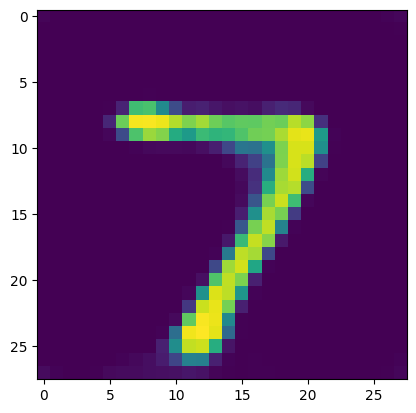

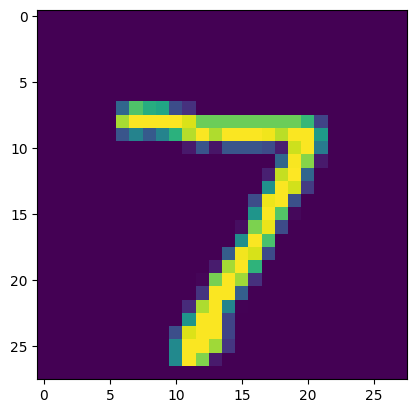

  0%|          | 0/313 [00:01<?, ?batch/s]


In [38]:
# train_losses, test_losses = train(model, train_dataloader, test_dataloader, num_epochs=5, learning_rate=1e-3)

# Plot one of the generated images
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      lesion = lesion.to(device)
      # lesion_free = lesion_free.to(device)
      recon = model(lesion)
      if batch_idx % 10 == 0:
        # tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        # Define scaling factors
        big_scale = 1.01
        small_scale = 0.99

        # Scale the array
        recon = recon[0][0].cpu().numpy()
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        # print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        # plt.imshow(lesion_free[0][0].cpu().numpy())
        # plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break